## Observations and Insights 

In [1]:
%load_ext lab_black

In [2]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)

# Combine the data into a single dataset
df = pd.merge(mouse_metadata, study_results, how="outer", on="Mouse ID")

## why can't i string all these replaces together?
# Reformat column headers
df = df.rename(
    columns=lambda header_str: header_str.lower()
    .replace(" ", "_")
    .replace(")", "")
    .replace("(", "")
)

# df["mouseid"] = df["mouse_id"]

# Display the data table for preview
# df.head()
df.shape

(1893, 8)

In [3]:
# Checking the number of mice.

df = df.drop_duplicates()

# get only the columns i need
df_minimized = df[["mouse_id", "timepoint", "drug_regimen"]]

# add in a count
df_count = (
    df_minimized.groupby(by=["mouse_id", "timepoint", "drug_regimen"])["mouse_id"]
    .count()
    .reset_index(name="count")
)
# print(df_count3)

In [4]:
# Optional: Get all the data for the duplicate mouse ID.

# list of mice with duplicate values
df_count[df_count["count"] > 1].sort_values(by="timepoint")

,mouse_id,timepoint,drug_regimen,count
587,g989,5,Propriva,2
588,g989,10,Propriva,2
589,g989,15,Propriva,2
590,g989,20,Propriva,2


In [5]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.

df = df[df.mouse_id != "g989"]

In [18]:
# Checking the number of mice in the clean DataFrame.

df.head()

# df[df["mouse_id"] == "g989"].sort_values(by="timepoint")

# df.shape

# df[df["count"] > 1].sort_values(by="timepoint")

# df.sort_values(by="count")

,mouse_id,drug_regimen,sex,age_months,weight_g,timepoint,tumor_volume_mm3,metastatic_sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1


## Summary Statistics

In [110]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen
# This method is the most straighforward, creating multiple series and putting them all together at the end.


# Get only the data I need for this
df_regimen = df[["drug_regimen", "tumor_volume_mm3"]]
# print(df_regimen)

# how many regimens?
regimen_count = len(df_regimen["drug_regimen"].unique())
# print(f"There are {regimen_count} regimens")

# get the mean
regimen_mean = df.groupby(by=["drug_regimen"]).mean()
print(regimen_mean)

# get the median
regimen_median = df.groupby(by=["drug_regimen"]).median()
print(regimen_median.shape)

# get the variance
regimen_variance = df.groupby(by=["drug_regimen"]).var()
# print(regimen_variance.shape)

# get the standard deviation
regimen_standdev = df.groupby(by=["drug_regimen"]).std()
# print(regimen_standdev.shape)
# print(regimen_standdev)

# get the SEM
regimen_sem = df.groupby(by=["drug_regimen"]).sem()
# print(regimen_sem.shape)

##why am i getting this error?
# put them all together
pd.DataFrame(
    {
        "Mean": regimen_mean["tumor_volume_mm3"],
        "Median": regimen_median["tumor_volume_mm3"],
        "Variance": regimen_variance["tumor_volume_mm3"],
        "Standard Deviation": regimen_standdev["tumor_volume_mm3"],
        "SEM": regimen_sem["tumor_volume_mm3"],
    },
)

              age_months   weight_g  timepoint  tumor_volume_mm3  \
drug_regimen                                                       
Capomulin      13.456522  19.965217  21.565217         40.675741   
Ceftamin       13.247191  27.398876  19.747191         52.591172   
Infubinol      16.230337  27.196629  18.174157         52.884795   
Ketapril       15.659574  27.861702  19.707447         55.235638   
Naftisol       12.000000  27.166667  19.623656         54.331565   
Placebo        10.734807  27.928177  18.674033         54.033581   
Propriva       10.006757  27.135135  17.060811         52.320930   
Ramicane       10.684211  19.679825  21.425439         40.216745   
Stelasyn       12.784530  27.856354  19.226519         54.233149   
Zoniferol      12.598901  27.692308  19.368132         53.236507   

              metastatic_sites  regimen_count  
drug_regimen                                   
Capomulin             0.713043            NaN  
Ceftamin              1.179775         

,Mean,Median,Variance,Standard Deviation,SEM
drug_regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


In [116]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen
# This method produces everything in a single groupby function

# get the summary data
regimen_summary = df.groupby(by=["drug_regimen"]).aggregate(
    {"tumor_volume_mm3": ["mean", "median", "var", "std", "sem"]}
)

print(regimen_summary)

             tumor_volume_mm3                                          
                         mean     median        var       std       sem
drug_regimen                                                           
Capomulin           40.675741  41.557809  24.947764  4.994774  0.329346
Ceftamin            52.591172  51.776157  39.290177  6.268188  0.469821
Infubinol           52.884795  51.820584  43.128684  6.567243  0.492236
Ketapril            55.235638  53.698743  68.553577  8.279709  0.603860
Naftisol            54.331565  52.509285  66.173479  8.134708  0.596466
Placebo             54.033581  52.288934  61.168083  7.821003  0.581331
Propriva            52.320930  50.446266  43.852013  6.622085  0.544332
Ramicane            40.216745  40.673236  23.486704  4.846308  0.320955
Stelasyn            54.233149  52.431737  59.450562  7.710419  0.573111
Zoniferol           53.236507  51.818479  48.533355  6.966589  0.516398


## Bar and Pie Charts

<AxesSubplot:>

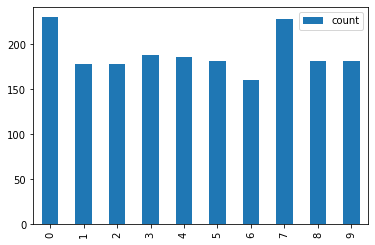

In [93]:
# Generate a bar plot showing the total number of mice for each treatment throughout the course of the study using pandas.

df_count_bar = (
    df_minimized.groupby(by=["drug_regimen"])["mouse_id"]
    .count()
    .reset_index(name="count")
)
# print(df_count_bar)

df_count_bar.plot.bar()

<function matplotlib.pyplot.show(close=None, block=None)>

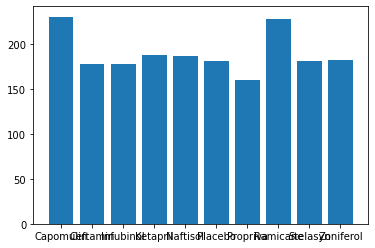

In [89]:
# Generate a bar plot showing the total number of mice for each treatment throughout the course of the study using pyplot.

# df["drug_regimen"].unique()

# Ramicane = 0
# Capomulin = 0
# Infubinol = 0
# Placebo = 0
# Ceftamin = 0
# Stelasyn = 0
# Zoniferol = 0
# Ketapril = 0
# Propriva = 0
# Naftisol = 0


# def drug_count(i):
#     for i in df:
#         if df["drug_regimen"] == "Ramicane":
#             Ramicane += 1
#         elif df["drug_regimen"] == "Capomulin":
#             Capomulin += 1
#         elif df["drug_regimen"] == "Infubinol":
#             Infubinol += 1
#         elif df["drug_regimen"] == "Placebo":
#             Placebo += 1
#         elif df["drug_regimen"] == "Ceftamin":
#             Ceftamin += 1
#         elif df["drug_regimen"] == "Stelasyn":
#             Stelasyn += 1
#         elif df["drug_regimen"] == "Zoniferol":
#             Zoniferol += 1
#         elif df["drug_regimen"] == "Ketapril":
#             Ketapril += 1
#         elif df["drug_regimen"] == "Propriva":
#             Propriva += 1
#         else:
#             Naftisol += 1
#     print(
#             Ramicane,
#             Capomulin,
#             Infubinol,
#             Placebo,
#             Ceftamin,
#             Stelasyn,
#             Zoniferol,
#             Ketapril,
#             Propriva,
#             Naftisol,
#             )


# drug_count(df)


df_count_bar = (
    df_minimized.groupby(by=["drug_regimen"])["mouse_id"]
    .count()
    .reset_index(name="count")
)
# print(df_count_bar)

plt.bar(df_count_bar["drug_regimen"], df_count_bar["count"])
plt.show

In [ ]:
# Generate a pie plot showing the distribution of female versus male mice using pandas



In [ ]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot

labels = "m"


## Quartiles, Outliers and Boxplots

In [ ]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin

# Start by getting the last (greatest) timepoint for each mouse


# Merge this group df with the original dataframe to get the tumor volume at the last timepoint


In [ ]:
# Put treatments into a list for for loop (and later for plot labels)


# Create empty list to fill with tumor vol data (for plotting)


# Calculate the IQR and quantitatively determine if there are any potential outliers. 

    
    # Locate the rows which contain mice on each drug and get the tumor volumes
    
    
    # add subset 
    
    
    # Determine outliers using upper and lower bounds
    

In [ ]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest


## Line and Scatter Plots

<function matplotlib.pyplot.show(close=None, block=None)>

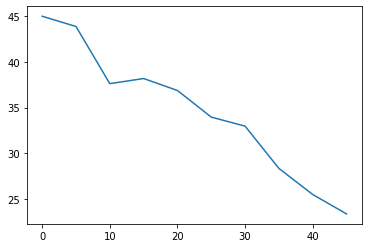

In [65]:
# Generate a line plot of time point versus tumor volume for a mouse treated with Capomulin

# Narrow down list to one mouse
df_capo = df[df["drug_regimen"] == "Capomulin"]
# print(df_capo)
df_capo1 = df[df["mouse_id"] == "s185"]
# print(df_capo1)

# Plot data
plt.plot(df_capo1["timepoint"], df_capo1["tumor_volume_mm3"])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

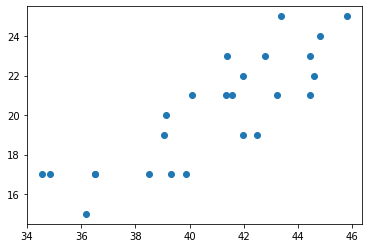

In [83]:
# Generate a scatter plot of mouse weight versus average tumor volume for the Capomulin regimen
df_capo_vol = df_capo.groupby(by=["mouse_id"]).mean()
# df_capo_vol

plt.scatter(df_capo_vol["tumor_volume_mm3"], df_capo_vol["weight_g"])
plt.show

# df_capo

In [ ]:
# Calculate the correlation coefficient and linear regression model 
# for mouse weight and average tumor volume for the Capomulin regimen
